<a href="https://colab.research.google.com/github/agustinparada/Fisica_Computacional_I/blob/master/Evaluacion3/Evaluacion3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Evaluación 3***

José Agustín Parada Peralta.

Departamento de Física.

Universidad de Sonora.

La Ecuación Diferencial que describe la Reacción - Difusión de una reacción química viene dada por:

$$ \frac{\partial u}{\partial t} = D\frac{\partial^2u}{\partial x^2} + R(u) $$

Donde $D$ es el coeficiente de difusión, y $R(u)$ es una función de reacción.

En nuestro caso, es de interés trabajar con el caso donde $R(u) = \alpha u$. Por ende, la ecuación resulta:

$$ \frac{\partial u}{\partial t} = D\frac{\partial^2u}{\partial x^2} + \alpha u $$

Si no se indica un caso distinto, vamos a asignar los valores $\alpha = -1$ y $D = 1$. También suponemos que tratamos con un tubo de longitud $L = 1$, de forma que $x\in(0,1)$. Asimismo, al iniciar, el tubo se encuentra vacío, esto es $u(x,0) = 0$.

Para los distintos problemas, se utilizarán los códigos realizado por el Dr. Vivi Andasari para la resolución de EDP con valores en la frontera de tipo Dirichlet y Neumann. El código producido por el Dr. Andasari, se basa en el método de solución de diferencias finitas, específicamente el de BTCS (Back Time Centered Space)



In [22]:
import numpy as np
from scipy import sparse
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# ***Problema 1***
Se reslverá la ecuación de Reacción/Difusión para la condición inicial:
$$ u(x,0) = 0 $$

Y las condiciones a la frontera de tipo Dirichlet:

\begin{align*}
u(0,t) & = 1\\
u(1,t) & = 2\\
\end{align*}

Realizar la solución numérica para $t \in [0,1]$.

True


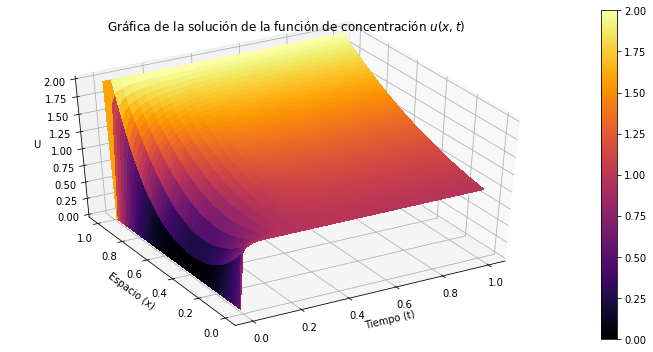

In [41]:
'''
Método de diferencias finitas hacia atrás para resolver la ecuación de
Reacción / Difusión:
u_t = D*u_xx + αu

Contando con condiciones a la frontera de tipo Dirichlet:
u(x_0,t) = f(x_0); u(x_L,t) = g(x_L)

Condición inicial u(x,0) = 0.

Código por el Dr. Vivi Andasari, Universidad de Boston.
'''

M = 50 # Número de pasos para el intervalo espacial
N = 60 # Número de pasos para el intervalo temporal

x0 = 0 # Inicio del intervalo
xL = 1 # Fin del intervalo de x. (Longitud del tubo)

# ----- Discretización espacial -----
dx = (xL - x0)/(M - 1)  # Tamaño de paso espacial

t0 = 0 # Inicio del intervalo de tiempo
tF = 1 # Fin del intervalo de tiempo (tiempo de reacción)

# ----- Pasos temporales (discretización temporal) -----
dt = (tF - t0)/(N - 1) # Tamaño de paso temporal

D = 1  # Coeficiente de difusión
alpha = -1 # Razón de reacción

r = dt*D/dx**2  # Cambios de variable para facilitación de aplicación del método
s = dt*alpha;

xspan = np.linspace(x0, xL, M)  # Vector con M puntos en x (inicio x0 a final xL)
tspan = np.linspace(t0, tF, N)  # Vector con N puntos en el tiempo (inicio t0 a final tf)

main_diag = (1 + 2*r - s)*np.ones((1,M-2))  # Para resolución del sistema
# de ecuaciones lineales AU = F, esta representa la diagonal principal de la matriz A
off_diag = -r*np.ones((1, M-3))  # Diagonal inferior y superior de la principal de 
# la matriz A

a = main_diag.shape[1]

diagonals = [main_diag, off_diag, off_diag]

A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray() #Declaración de la 
# matriz A como sparse matrix, con el objetivo de ahorro de memoria, eliminando 
# ceros innecesarios

# ----- Inicializar matriz U -----
U = np.zeros((M, N))

#----- Condición inicial -----
U[:,0] = 0

#----- Condiciones a la frontera de Dirichlet -----
U[0,:] = 1
U[-1,:] = 2

# Loop de resolución del sistema AU = F, resolver para U:

for k in range(1, N):
    c = np.zeros((M-4,1)).ravel()
    b1 = np.asarray([r*U[0,k], r*U[-1,k]])
    b1 = np.insert(b1, 1, c)
    b2 = np.array(U[1:M-1, k-1])
    b = b1 + b2  # Right hand side
    U[1:M-1, k] = np.linalg.solve(A,b)  # Solve x=A\b

# ----- Si la solución es correcta, se imprime TRUE:
g = np.allclose(np.dot(A,U[1:M-1,N-1]), b)
print(g)

# ----- Gráfico de la superficie de la solución -----
X, T = np.meshgrid(tspan, xspan)

fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, T, U, linewidth=0,
                       cmap=cm.inferno, antialiased=False)


ax.view_init(40,-120)
ax.set_title('Gráfica de la solución de la función de concentración $u(x,t)$')
m=cm.ScalarMappable(cmap='inferno')
m.set_array(U)
plt.colorbar(m)
ax.set_xlabel('Tiempo (t)')
ax.set_ylabel('Espacio (x)')
ax.set_zlabel('U')
plt.tight_layout()
plt.show()

***Comentarios del resultado obtenido***:

Se puede apreciar que los extremos del tubo siempre se mantienen con su respectiva concentración (2 y 1, según sea el extremo del tubo). Además, cómo el tubo se comienza a llenar de ambos lados, el gas reacciona y el muy poco tiempo la concentración llega a un equilibrio, por así decirlo. 

Deja de variar temporalmente, pero la concentración del compuesto sigue variando según la posición del tubo.

# ***Problema 2***

Ahora, se colocan reguladores de presión, permitiendo el flujo de los gases desde los reservorios hacia el tubo. El cual se encuentra inicialmente en vacío, esto es:

$$ u(x,0) = 0 $$

Además, se cuenta con las condiciones a la frontera tipo Neumann:

\begin{align*}
\frac{\partial u}{\partial x}(0,t) & = 0.1\\
\frac{\partial u}{\partial x}(1,t) & = 0.2\\
\end{align*}

Se realizarán los cálculos para $t \in [0,10]$.

True


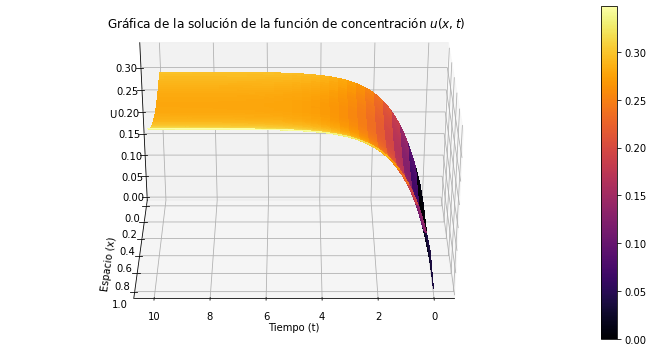

In [42]:
'''
Método de diferencias finitas hacia atrás para resolver la ecuación de
Reacción / Difusión:
u_t = D*u_xx + αu

Contando con condiciones a la frontera de tipo Neumann:
u_x(x_0,t) = f(x_0); u_x(x_L,t) = g(x_L)

Condición inicial u(x,0) = 0.

Código por el Dr. Vivi Andasari, Universidad de Boston.
'''


M = 50 # Número de pasos para el intervalo espacial
N = 60 # Número de pasos para el intervalo temporal

x0 = 0 # Inicio del intervalo en x
xL = 1 # Fin del intervalo de x. (Longitud del tubo)

# ----- Discretización espacial -----
dx = (xL - x0)/(M - 1) # Tamaño de paso espacial

t0 = 0  # Inicio del intervalo de tiempo
tF = 10 # Fin del intervalo de tiempo (tiempo de reacción)

# ----- Pasos temporales (discretización temporal)  -----
dt = (tF - t0)/(N - 1)

D = 1  # Coeficiente de difusión
alpha = -1 # Razón de reacción

r = dt*D/dx**2  # Cambios de variable para facilitación de aplicación del método
s = dt*alpha
a = 1 + 2*r - s


xspan = np.linspace(x0, xL, M)  # Vector con M puntos en x (inicio x0 a final xL)
tspan = np.linspace(t0, tF, N)  # Vector con N puntos en el tiempo (inicio t0 a final tf)

main_diag = (1 + 2*r - s)*np.ones((1,M))  # Para resolución del sistema
# de ecuaciones lineales AU = F, esta representa la diagonal principal de la matriz A
off_diag = -r*np.ones((1, M-1))  # Diagonal inferior y superior de la principal de 
# la matriz A

a = main_diag.shape[1]

diagonals = [main_diag, off_diag, off_diag]

A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
A[0,1] = -2*r
A[M-1,M-2] = -2*r  #Declaración de la 
# matriz A como sparse matrix, con el objetivo de ahorro de memoria, eliminando 
# ceros innecesarios

# ----- Iniciar la matriz U -----
U = np.zeros((M, N))

#----- Condición inicial -----
U[:,0] = 0

#----- Condiciones a la frontera de Neumann -----
leftBC = np.arange(1, N+1)
f = 0.1*np.ones(leftBC.shape)

rightBC = np.arange(1, N+1)
g = 0.2*np.ones(rightBC.shape)

# Loop de resolución del sistema AU = F, resolver para U:
for k in range(1, N):
    c = np.zeros((M-2,1)).ravel()
    b1 = np.asarray([2*r*dx*f[k], 2*r*dx*g[k]])
    b1 = np.insert(b1, 1, c)
    b2 = np.array(U[0:M, k-1])
    b = b1 + b2  # Right hand side
    U[0:M, k] = np.linalg.solve(A,b)  # Solve x=A\b

# ----- Verifica si la solución es correcta. En cuyo caso es TRUE:
gc = np.allclose(np.dot(A,U[0:M,N-1]), b)
print(gc)

# ----- Graficación de la superficie de solución -----
X, T = np.meshgrid(tspan, xspan)

fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, T, U, linewidth=0,
                       cmap=cm.inferno, antialiased=False)

ax.view_init(elev=30,azim=90)
ax.set_title('Gráfica de la solución de la función de concentración $u(x,t)$')
m=cm.ScalarMappable(cmap='inferno')
m.set_array(U)
plt.colorbar(m)
ax.set_xlabel('Tiempo (t)')
ax.set_ylabel('Espacio (x)')
ax.set_zlabel('U')
plt.tight_layout()


***Comentarios del resultado obtenido***:

Similar al problema anterior, el tubo comienza a llenarse rápidamente (aumento rápido de la concentración). No obstante, se puede observar que de un lado del tubo la concentración aumenta con mayor velocidad que en el otro extremo. Esto se debe a las condiciones a la frontera de tipo Neumann que implementamos.

De igual forma, se llega a un equilibrio de la concentración (temporal) después de $t = 4$.

# ***Problema 3***

En esta ocasión, se juntan dos gases que son inertes entre sí, no existe una reacción química entre ellos, lo que implica que $\alpha = 0$. Luego, se cuenta con la condición inicial:

$$ u(x,0)=0 $$

También, se tienen las condiciones a la frontera de tipo Dirichlet:

\begin{align*}
u(0,t) & = 1\\
u(1,t) & = 2
\end{align*}

Se realizará la simulación para $t \in [0,10]$.

True


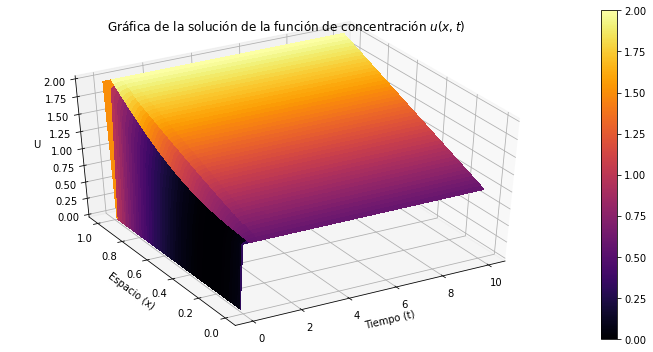

In [43]:
'''
Método de diferencias finitas hacia atrás para resolver la ecuación de
Reacción / Difusión:
u_t = D*u_xx + αu

Contando con condiciones a la frontera de tipo Dirichlet:
u(x_0,t) = f(x_0); u(x_L,t) = g(x_L)

Condición inicial u(x,0) = 0.

Código por el Dr. Vivi Andasari, Universidad de Boston.
'''

M = 50 # Número de pasos para el intervalo espacial
N = 60 # Número de pasos para el intervalo temporal

x0 = 0 # Inicio del intervalo
xL = 1 # Fin del intervalo de x. (Longitud del tubo)

# ----- Discretización espacial -----
dx = (xL - x0)/(M - 1)  # Tamaño de paso espacial

t0 = 0 # Inicio del intervalo de tiempo
tF = 10 # Fin del intervalo de tiempo (tiempo de reacción)

# ----- Pasos temporales (discretización temporal) -----
dt = (tF - t0)/(N - 1) # Tamaño de paso temporal

D = 1  # Coeficiente de difusión
alpha = 0 # Razón de reacción

r = dt*D/dx**2  # Cambios de variable para facilitación de aplicación del método
s = dt*alpha;

xspan = np.linspace(x0, xL, M)  # Vector con M puntos en x (inicio x0 a final xL)
tspan = np.linspace(t0, tF, N)  # Vector con N puntos en el tiempo (inicio t0 a final tf)

main_diag = (1 + 2*r - s)*np.ones((1,M-2))  # Para resolución del sistema
# de ecuaciones lineales AU = F, esta representa la diagonal principal de la matriz A
off_diag = -r*np.ones((1, M-3))  # Diagonal inferior y superior de la principal de 
# la matriz A

a = main_diag.shape[1]

diagonals = [main_diag, off_diag, off_diag]

A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray() #Declaración de la 
# matriz A como sparse matrix, con el objetivo de ahorro de memoria, eliminando 
# ceros innecesarios

# ----- Inicializar matriz U -----
U = np.zeros((M, N))

#----- Condición inicial -----
U[:,0] = 0

#----- Condiciones a la frontera de Dirichlet -----
U[0,:] = 1
U[-1,:] = 2

# Loop de resolución del sistema AU = F, resolver para U:

for k in range(1, N):
    c = np.zeros((M-4,1)).ravel()
    b1 = np.asarray([r*U[0,k], r*U[-1,k]])
    b1 = np.insert(b1, 1, c)
    b2 = np.array(U[1:M-1, k-1])
    b = b1 + b2  # Right hand side
    U[1:M-1, k] = np.linalg.solve(A,b)  # Solve x=A\b

# ----- Si la solución es correcta, se imprime TRUE:
g = np.allclose(np.dot(A,U[1:M-1,N-1]), b)
print(g)

# ----- Gráfico de la superficie de la solución -----
X, T = np.meshgrid(tspan, xspan)

fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, T, U, linewidth=0,
                       cmap=cm.inferno, antialiased=False)

ax.set_title('Gráfica de la solución de la función de concentración $u(x,t)$')
m=cm.ScalarMappable(cmap='inferno')
m.set_array(U)
plt.colorbar(m)
ax.view_init(40,-120)
ax.set_xlabel('Tiempo (t)')
ax.set_ylabel('Espacio (x)')
ax.set_zlabel('U')
plt.tight_layout()
plt.show()

***Comentarios del resultado obtenido***:

Se puede observar, como en el problema 1, que la concentración en los extremos del tubo se mantiene constante en el tiempo (1 o 2, según sea el extremo del tubo).

No obstante, el equilibrio temporal en la concentración es notablemente más pronto que ne los problemas anteriores. Esto se debe a que la razón de reacción $\alpha = 0$, los gases son inertes entre sí, no reaccionan y por ello el equilibrio se alcanza rápidamente. Sin embargo, se mantienen las diferencias de concentración entre los extremos del tubo pues se trata con sustancias distintas.